Spring has just barely begun here in Houston, Texas, and normally we are blessed with beautiful sunny or rainy days with relatively cooler (for Houston) temperatures. However I have noticed that the weather here in Houston is a bit warmer, and humid this spring than what I am normally used to. Perhaps, my body's sensory inputs about weather variations are off target this year. Or , this is an outlier from the normal spring temperatures just appearing this year. Regardless, I am curious to find out if there is an overall trend over time towards warmer temperatures during spring. But, since I am at it, I am going to also investigate the temperature trends overall for Houston for seasons, including spring.  
Much literature has been published on the earth's increasing temperature profiles and the attribution to anthropegenic production of greenhouse gases, especially carbon dioxide. Here in this analysis, I am not seeking out the causes of the changes (if any) in the temperatures, but merely investigating the trends in the Houston temperatures with the tools of  Exploratory Data Analysis (EDA).  
EDA is utilized on Houston's dry-bulb temperature data available for the Years: 1973 to 2019, to see if there shifts in the observed data during this given time period.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore') # suppresses messages and warnings

## Houston Weather Data - 1973 to 2019

The hourly climatological data for Houston's Intercontinental Airport, covering the Years 1973 - 2019, was obtained from the National Oceanic and Atmospheric Administration (NOAA) Local Climatological Data site:  
https://www.ncdc.noaa.gov/cdo-web/datatools/lcd.

The data was filtered to extract only the Dry-Bulb temperatures.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
hou = pd.read_csv('HouTPW.csv', index_col='DATE',parse_dates=True)
hou = hou.loc[:,['HourlyDryBulbTemperature']]
hou.columns = ['DryBulbTemperature']
hou.index.name = 'Date'
hou = hou.loc[:'2019']
hou

,DryBulbTemperature
Date,
1973-01-01 00:00:00,53
1973-01-01 01:00:00,52
1973-01-01 02:00:00,52
1973-01-01 03:00:00,52
1973-01-01 04:00:00,52
...,...
2019-12-31 19:53:00,49
2019-12-31 20:53:00,47
2019-12-31 21:53:00,46


In [4]:
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578567 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DryBulbTemperature  483326 non-null  object
dtypes: object(1)
memory usage: 8.8+ MB


### Data Preprocessing

Data that has the letter "s" appearing after the value are designated as suspect values, per the NOAA data documentation. 
Listed below are the number of suspect values in the temperature variable:

In [5]:
np.sum(hou.DryBulbTemperature.str.contains("s",na=False))

124

This temperature data also contains the string "*"

In [6]:
np.sum(hou.DryBulbTemperature.str.contains("\*",na=False)) #  \ is placed before * to escape term, otherwise it is interpreted as regex metacharacters

6

These suspect values will be removed from the dataset.  

In [7]:
hou=hou[~hou.DryBulbTemperature.str.contains("s|\*", na=False)] 

In [8]:
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578437 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DryBulbTemperature  483196 non-null  object
dtypes: object(1)
memory usage: 8.8+ MB


The temperature values in the dataframe are all strings, hence must be converted to numeric values.

In [9]:
hou['DryBulbTemperature'] = pd.to_numeric(hou['DryBulbTemperature'])

In [10]:
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578437 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DryBulbTemperature  483196 non-null  float64
dtypes: float64(1)
memory usage: 8.8 MB


About 17% of the temperature dataset contains missing values.

In [11]:
hou = hou.dropna()
hou.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483196 entries, 1973-01-01 00:00:00 to 2019-12-31 23:53:00
Data columns (total 1 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DryBulbTemperature  483196 non-null  float64
dtypes: float64(1)
memory usage: 7.4 MB


## Exploratory Data Analysis

**“Exploratory data analysis can never be the whole story, but nothing else can serve as the foundation stone.” —John Tukey**

### Daily Maximum Temperatures

In [12]:
houMaxT = hou['DryBulbTemperature'].resample('D').max()
houMaxT = pd.DataFrame(houMaxT)

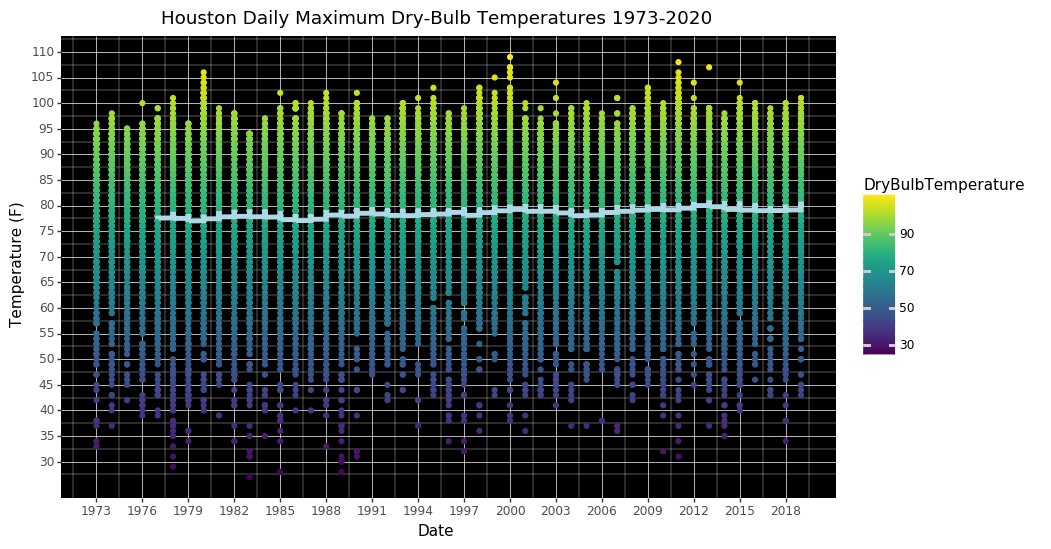

<ggplot: (128418654647)>

In [48]:
from plotnine import *
from plotnine.scales import scale_x_date, scale_y_continuous
from mizani.breaks import date_breaks, minor_breaks
from mizani.formatters import date_format
%matplotlib inline

(ggplot(houMaxT)
 + aes(x='houMaxT.index.year', y='DryBulbTemperature', color='DryBulbTemperature')
 + geom_point() 
 + labs(title='Houston Daily Maximum Dry-Bulb Temperatures 1973-2020', x='Date', y='Temperature (F)')
 + geom_smooth(size=2,color="lightblue",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(30, 120, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

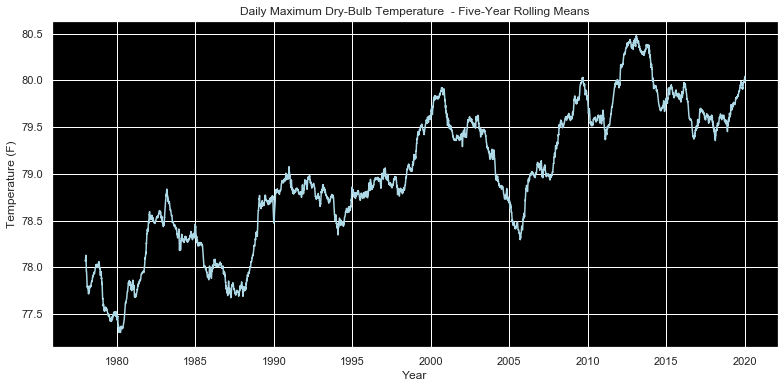

In [57]:
maMAX=houMaxT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maMAX.index,maMAX.values, color='lightblue')
_=plt.title('Daily Maximum Dry-Bulb Temperature  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature (F)')
plt.show()

### Daily Minimum Temperatures

In [14]:
houMinT = hou['DryBulbTemperature'].resample('D').min()
houMinT = pd.DataFrame(houMinT)

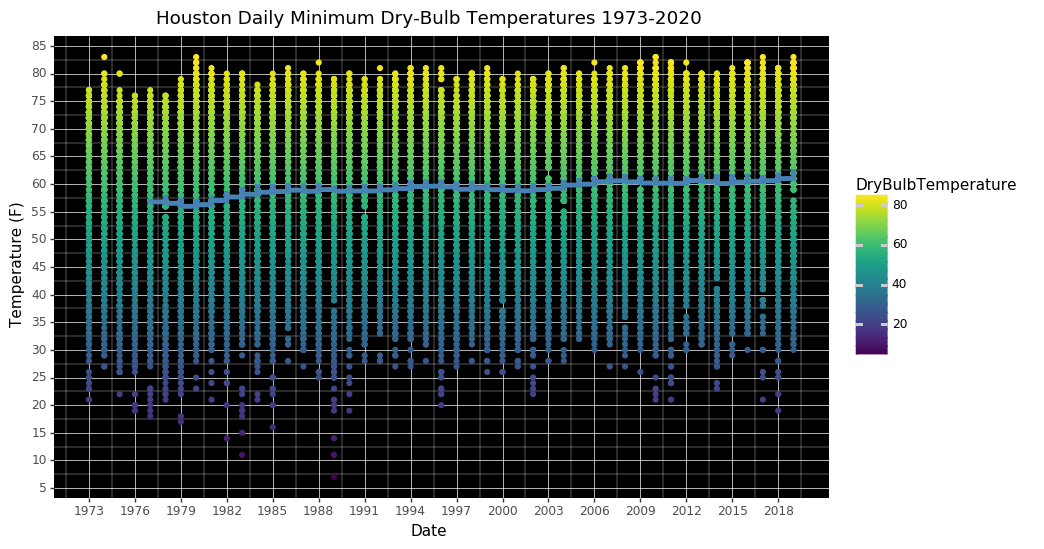

<ggplot: (-9223371908448570389)>

In [15]:
(ggplot(houMinT)
 + aes(x='houMinT.index.year', y='DryBulbTemperature', color='DryBulbTemperature')
 + geom_point() 
 + labs(title='Houston Daily Minimum Dry-Bulb Temperatures 1973-2020', x='Date', y='Temperature (F)')
 + geom_smooth(size=2,color="steelblue",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(5, 90, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

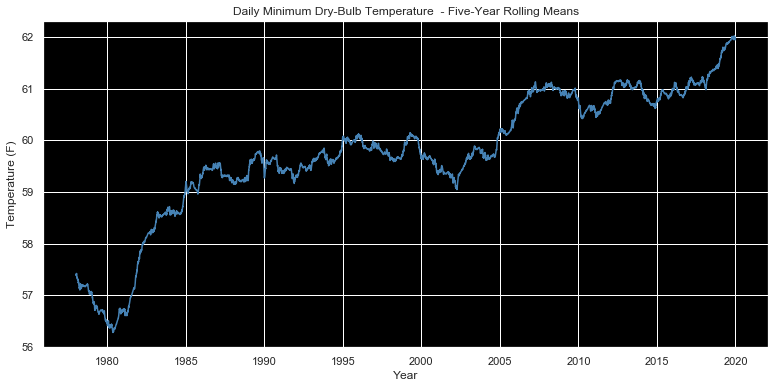

In [56]:
maMIN=houMinT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maMIN.index,maMIN.values, color='steelblue')
_=plt.title('Daily Minimum Dry-Bulb Temperature  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature (F)')
plt.show()

###  Daily Temperature Range

In [16]:
houDT = houMaxT-houMinT
houDT.columns = ['Tmax-Tmin']

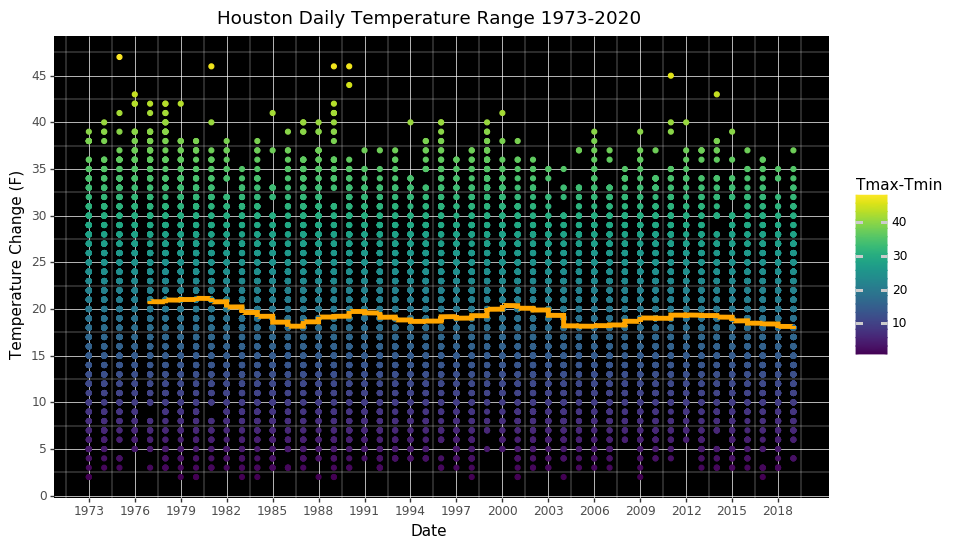

<ggplot: (-9223371908442442436)>

In [59]:
(ggplot(houDT)
 + aes(x='houDT.index.year', y='Tmax-Tmin', color='Tmax-Tmin')
 + geom_point() 
 + labs(title='Houston Daily Temperature Range 1973-2020', x='Date', y='Temperature Change (F)')
 + geom_smooth(size=2,color="Orange",method = "mavg", se=False)
 + scale_x_continuous(breaks=range(1970, 2020, 3))
 + scale_y_continuous(breaks=range(0, 50, 5))
 + theme(panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
         panel_grid_minor = element_line(size = 0.25, linetype = 'solid',colour = "white"),
         panel_background = element_rect(fill = 'black'),
         figure_size=(10, 6)
))

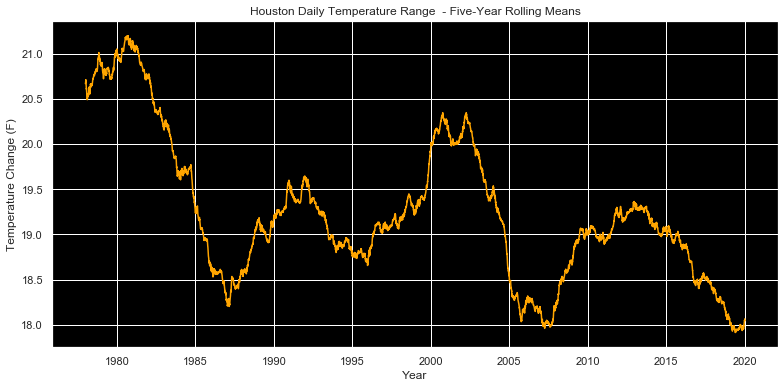

In [60]:
maDT=houDT.rolling(1826).mean()
_=plt.figure(figsize=(13,6))
ax = plt.axes()
ax.set_facecolor('black')
_=plt.plot(maDT.index,maDT.values, color='orange')
_=plt.title('Houston Daily Temperature Range  - Five-Year Rolling Means')
_=plt.xlabel('Year')
_=plt.ylabel('Temperature Change (F)')
plt.show()

 ### Variation of  Mean Monthly Temperatures over Time

In [18]:
houMon = hou['DryBulbTemperature'].resample('M').mean()

#### Winter Months

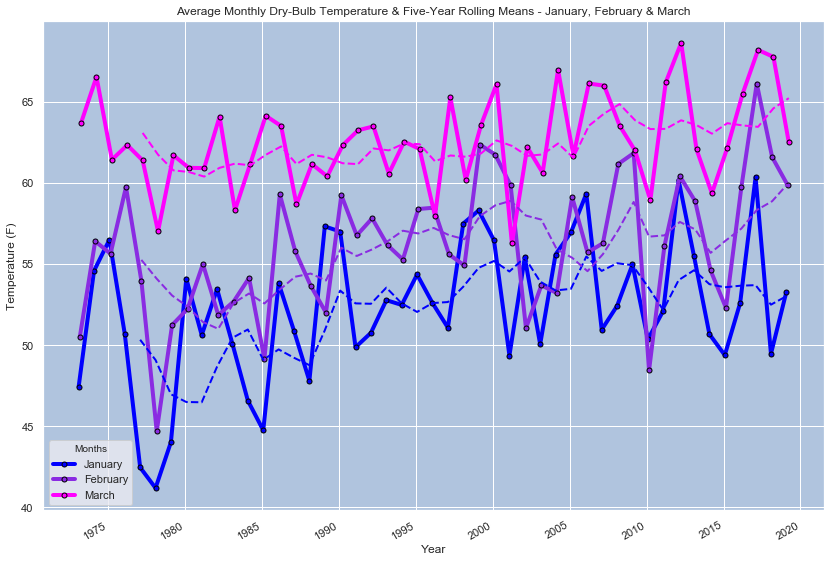

In [19]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('lightsteelblue')
colors=['blue','blueviolet','magenta']
for i in range(1,4):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=4,color=colors[i-1],
              marker='o',markersize=5,markerfacecolor=colors[i-1],
         markeredgecolor='black')
    
labels = ['January', 'February', 'March']
_=plt.legend(labels,title="Months",loc=1)    

for i in range(1,4):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-1],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - January, February & March")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')


plt.show()    

#### Spring Months

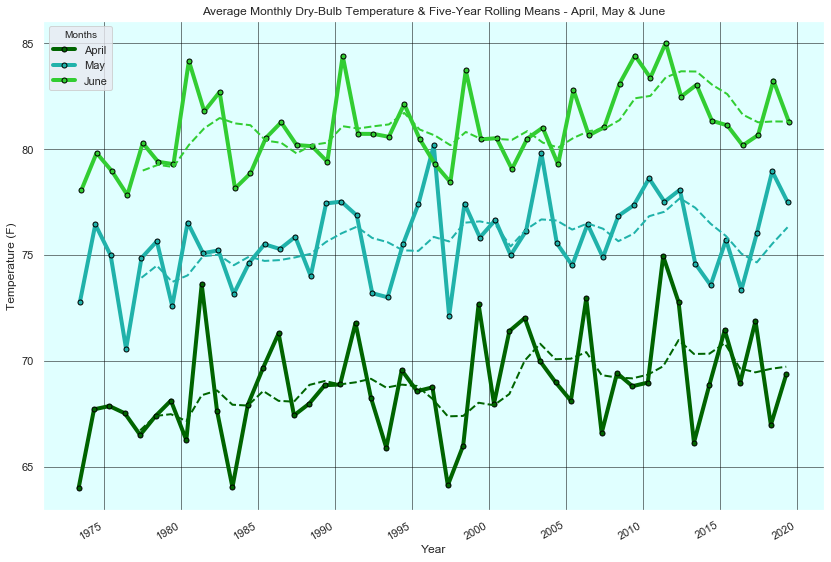

In [20]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('lightcyan')
colors=['darkgreen','lightseagreen','limegreen']
for i in range(4,7):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=4,color=colors[i-4],
              marker='o',markersize=5,markerfacecolor=colors[i-4],
         markeredgecolor='black')

_= plt.grid(axis='both',linewidth=0.5, color='black', linestyle='-')
labels = ['April', 'May', 'June']
_=plt.legend(labels,title="Months",loc=1)    

for i in range(4,7):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-4],linestyle='dashed',legend=False)

    
_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - April, May & June")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

plt.show()    

#### Summer Months

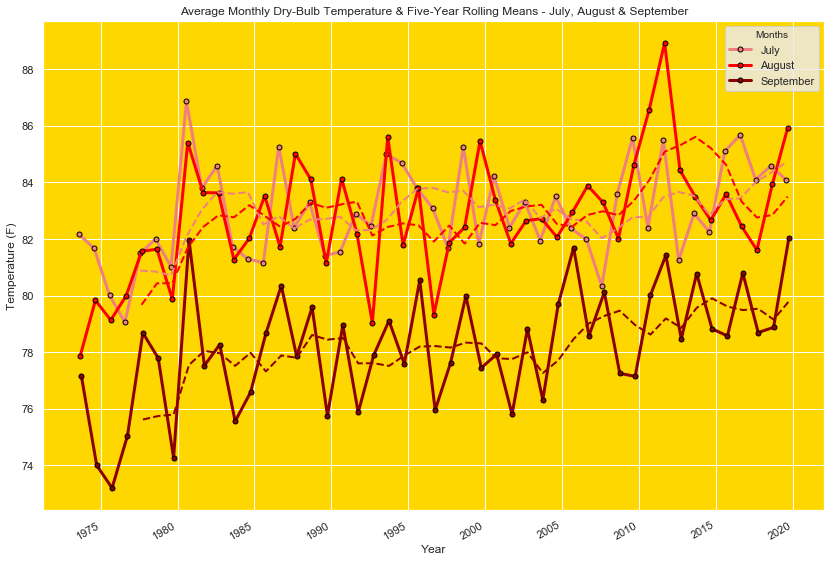

In [21]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('gold')
colors=['lightcoral','red','darkred']
for i in range(7,10):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=3,color=colors[i-7],
              marker='o',markersize=5,markerfacecolor=colors[i-7],
         markeredgecolor='black')
labels = ['July', 'August', 'September']
_=plt.legend(labels,title="Months",loc=1) 

for i in range(7,10):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-7],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - July, August & September")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

plt.show()    

#### Fall Months

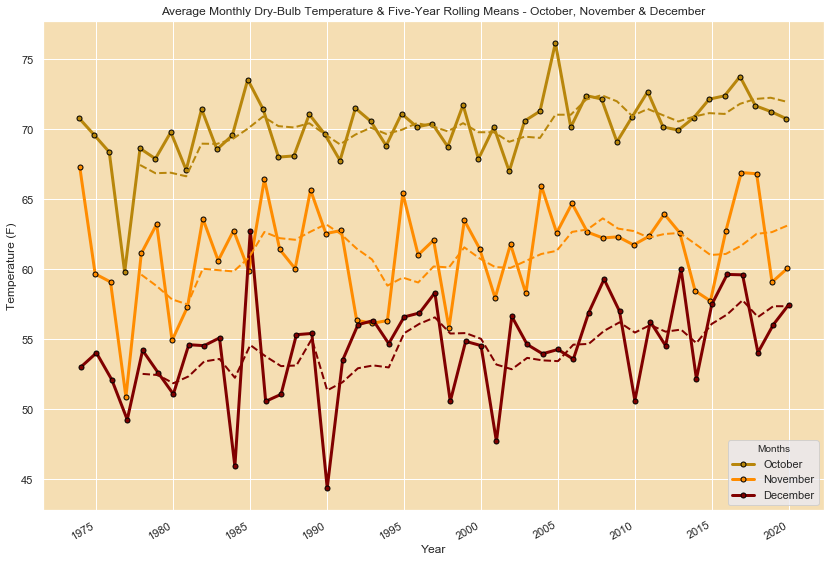

In [22]:
_= plt.figure(figsize=(14,10))
ax = plt.axes()
ax.set_facecolor('wheat')
colors=['darkgoldenrod','darkorange','maroon']
for i in range(10,13):
    _=plt.plot(houMon[houMon.index.month==i].index,houMon[houMon.index.month==i],label=i,linewidth=3,color=colors[i-10],
              marker='o',markersize=5,markerfacecolor=colors[i-10],
         markeredgecolor='black')
labels = ['October', 'November', 'December']
_=plt.legend(labels,title="Months",loc=1) 

for i in range(10,13):
    # Compute the five year rolling means 
    ma = houMon[houMon.index.month==i].rolling(window=5).mean()
    _=ma.plot(linewidth=2, color=colors[i-10],linestyle='dashed',legend=False)

_= plt.title("Average Monthly Dry-Bulb Temperature & Five-Year Rolling Means - October, November & December")
_= plt.xlabel('Year')
_= plt.ylabel('Temperature (F)')

_=plt.legend(labels,title="Months",loc=4)
plt.show()    

### Variations of Temperatures at Decadal  Intervals

In [23]:
def decades(df):
    '''A function to subset temp data by decades'''
    the1970s = df.loc['1973':'1979','DryBulbTemperature']
    the1980s = df.loc['1980':'1989','DryBulbTemperature']
    the1990s = df.loc['1990':'1999','DryBulbTemperature']
    the2000s = df.loc['2000':'2009','DryBulbTemperature']
    the2010s = df.loc['2010':'2019','DryBulbTemperature']
    temps=[the1970s,the1980s,the1990s,the2000s,the2010s]
    label=['the1970s','the1980s','the1990s','the2000s','the2010s']
    
    return temps, label

#### Maximum Daily Temperature Decadal Variations

In [24]:
# subset max daily temp data by decades
temps, label = decades(houMaxT)

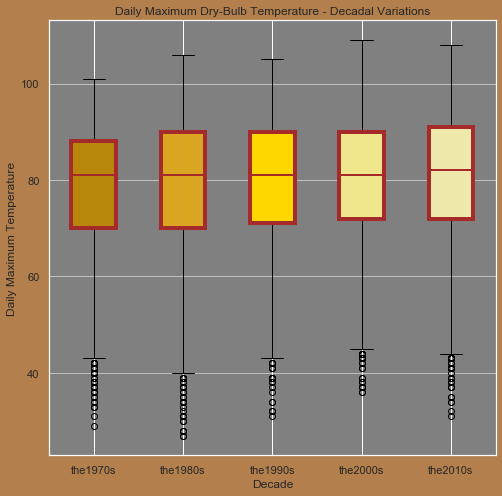

In [25]:
_= plt.figure(figsize=(8,8),facecolor=(.7,.5,.3))
ax = plt.axes()
# Setting the background color
ax.set_facecolor("grey")

boxprops = dict(linestyle='-', linewidth=4, color='brown')
medianprops = dict(linestyle='-', linewidth=2, color='brown')
box=plt.boxplot(temps, vert=True, patch_artist=True, labels=label,boxprops=boxprops,medianprops=medianprops)
_= plt.grid(axis='y',linewidth=0.5, color='white', linestyle='-')
_= plt.xlabel('Decade')
_= plt.ylabel('Daily Maximum Temperature')
_= plt.title('Daily Maximum Dry-Bulb Temperature - Decadal Variations')
colors = ['darkgoldenrod', 'goldenrod', 'gold', 'khaki','palegoldenrod']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [26]:
# Daily max temperature medians & means by decades
la=[lab for lab in label]
teMD=[np.median(t) for t in temps]
teMN=[round(np.mean(t),1) for t in temps]
maxT=pd.DataFrame(list(zip(teMD,teMN)),columns=['Median Daily Max Temp','Mean Daily Max Temp'],index=la)
maxT

,Median Daily Max Temp,Mean Daily Max Temp
the1970s,81.0,77.7
the1980s,81.0,78.5
the1990s,81.0,79.2
the2000s,81.0,79.2
the2010s,82.0,79.9


#### Minimum Daily Temperature Decadal Variations

In [27]:
# subset min daily temp data by decades
temps, label = decades(houMinT)

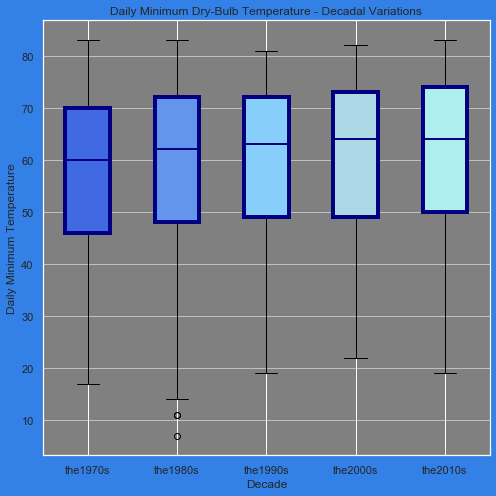

In [28]:
_= plt.figure(figsize=(8,8),facecolor=(.2,.5,.9))
ax = plt.axes()
# Setting the background color
ax.set_facecolor("grey")

boxprops = dict(linestyle='-', linewidth=4, color='navy')
medianprops = dict(linestyle='-', linewidth=2, color='navy')
box=plt.boxplot(temps, vert=True, patch_artist=True, labels=label,boxprops=boxprops,medianprops=medianprops)
_= plt.grid(axis='y',linewidth=0.5, color='white', linestyle='-')
_= plt.xlabel('Decade')
_= plt.ylabel('Daily Minimum Temperature')
_= plt.title('Daily Minimum Dry-Bulb Temperature - Decadal Variations')
colors = ['royalblue', 'cornflowerblue', 'lightskyblue', 'lightblue','paleturquoise']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [29]:
# Daily min temperature medians & means by decades
la=[lab for lab in label]
teMD=[np.median(t) for t in temps]
teMN=[round(np.mean(t),1) for t in temps]
minT = pd.DataFrame(list(zip(teMD,teMN)),columns=['Median Daily Min Temp','Mean Daily Min Temp'],index=la)
minT

,Median Daily Min Temp,Mean Daily Min Temp
the1970s,60.0,57.1
the1980s,62.0,59.2
the1990s,63.0,59.9
the2000s,64.0,60.5
the2010s,64.0,61.4


#### Daily Temperature Decadal Range Variations

In [30]:
# Combine the Daily Max and Min statistics into a single dataframe
rangeT = pd.concat([maxT,minT],axis=1)
rangeT['Mean Daily Temp Variation'] = rangeT['Mean Daily Max Temp'] - rangeT['Mean Daily Min Temp']
rangeT

,Median Daily Max Temp,Mean Daily Max Temp,Median Daily Min Temp,Mean Daily Min Temp,Mean Daily Temp Variation
the1970s,81.0,77.7,60.0,57.1,20.6
the1980s,81.0,78.5,62.0,59.2,19.3
the1990s,81.0,79.2,63.0,59.9,19.3
the2000s,81.0,79.2,64.0,60.5,18.7
the2010s,82.0,79.9,64.0,61.4,18.5


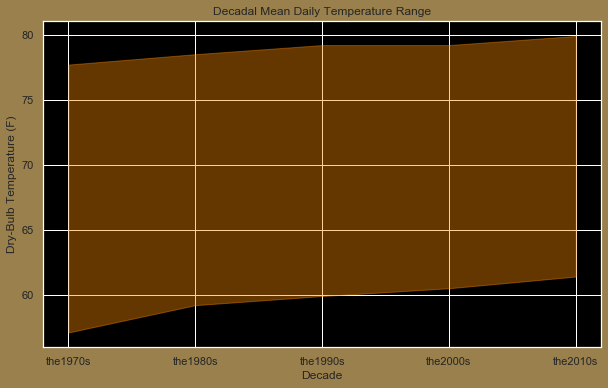

In [31]:
_= plt.figure(figsize=(10,6),facecolor=(.6,.5,.3))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
_= plt.fill_between(rangeT.index, rangeT['Mean Daily Max Temp'],rangeT['Mean Daily Min Temp'], color='darkorange',alpha=0.4)
_= plt.title('Decadal Mean Daily Temperature Range')
_= plt.xlabel('Decade')
_= plt.ylabel('Dry-Bulb Temperature (F)')
plt.show()